In [1]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import Normalize
import umap
import time
from astropy.visualization import ImageNormalize, PercentileInterval, LogStretch
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import cv2 

/home/msiudek/myspace/software/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-18 17:03:03.581089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742317383.739337  202394 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742317383.786443  202394 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 17:03:04.160216: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-cr

In [2]:
def extract_center_thumbnail(file_name, folder_path, size=112):
    """
    Extracts and normalizes the central region of a thumbnail from a FITS file.
    """
    try:
        file_path = os.path.join(folder_path, file_name)
        with fits.open(file_path) as hdul:
            image_data = hdul[0].data
            if image_data is None:
                raise ValueError("No image data found in FITS file.")
            # Normalize the image
            image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
            h, w = image_data.shape
            center_crop = image_data[h // 2 - size // 2: h // 2 + size // 2, w // 2 - size // 2: w // 2 + size // 2]
            return center_crop
    except Exception as e:
        print(f"Error loading file {file_name}: {e}")
        return np.zeros((size, size))  # Blank thumbnail for errors

In [3]:
def replace_luminosity_channel(rgb_image, rgb_channel_for_luminosity, desaturate_speckles= False):
    lab_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2LAB)
    # Replace L channel
    lab_image[:, :, 0] = rgb_image[:, :, rgb_channel_for_luminosity]
    # Convert back to RGB
    modified_rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

    if desaturate_speckles:
        modified_rgb_image = desaturate_bright_pixels(modified_rgb_image, 90)
    return modified_rgb_image

# this tends to give "blue speckles" from the blue channel/luminsity background
# desaturate individual pixels brighter than nearby pixels
def desaturate_bright_pixels(rgb_image, threshold):
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    # find highly saturated pixels
    saturation = hsv_image[:, :, 1]
    # saturation_nansafe = np.where
    # saturation_smoothed = cv2.medianBlur(saturation, 9)
    # saturation_diff = saturation - saturation_smoothed
    # desaturate highly saturated pixels
    # threshold = np.percentile(saturation, percentile)


    # threshold = threshold  # 0-255
    oversaturated = saturation > threshold
    hsv_image[:, :, 1] = np.clip(saturation, 0, threshold)
    lightness = hsv_image[:, :, 2]
    hsv_image[:, :, 2] = np.where(oversaturated, lightness * 0.5, lightness)

    # desaturation_factor = np.clip(saturation_diff / threshold, 0, 1)
    # hsv_image[:, :, 1] = hsv_image[:, :, 1] * (1 - desaturation_factor)
    # hsv_image[:, :, 2] = saturation_diff
    # Convert back to RGB
    modified_rgb_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    # modified_rgb_image = saturation > threshold

    # bkg = hsv_image[:, :, 2] < (median - std)

    # print(threshold, (saturation.min(), saturation.max()), saturation.mean(), (saturation > threshold).mean())
    # return saturation > 170
    return modified_rgb_image

In [4]:
def show_cutouts(file_names_vis, file_names_y, file_names_j, file_names_h, \
                      cutout_folder_vis, cutout_folder_y, cutout_folder_j, cutout_folder_h, 
                      size=112):

    def load_and_process_image(file_path, size, q, clip):
        """Helper function to load and process a single FITS file."""
        if os.path.exists(file_path):
            try:
                image_data = fits.getdata(file_path, ext=0)
                if image_data is None or image_data.size == 0:
                    raise ValueError("No valid image data found.")
                
                #image_data = np.flipud(image_data)
                image_data = np.arcsinh(image_data * q)
                if clip < 100:
                    image_data = np.clip(image_data, 0, np.percentile(image_data, clip))

                # Normalize the image
                #image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
                # Extract the central cutout
                h, w = image_data.shape
                image_data = image_data[h // 2 - size // 2: h // 2 + size // 2, w // 2 - size // 2: w // 2 + size // 2]
                # Clip the data to avoid oversaturation
                #interval = PercentileInterval(q)
                #clipped_data = interval(image_data)
                # Apply Asinh scaling to reduce brightness
                #scaled_data = np.arcsinh(clipped_data * stretch)
                return image_data #scaled_data / np.arcsinh(stretch)
            except Exception as e:
                #print(f"Error processing image {file_path}: {e}")
                return np.zeros((size, size))  # Return blank cutout for errors
        else:
            print(f"File not found: {file_path}")
            return np.zeros((size, size))  # Return blank cutout for missing files

    cutout_images = []
    invalid_count = 0

    for name_vis, name_y, name_j, name_h in zip(file_names_vis, file_names_y, file_names_j, file_names_h):
        path_y = os.path.join(cutout_folder_y, name_y)
        path_j = os.path.join(cutout_folder_j, name_j)
        path_h = os.path.join(cutout_folder_h, name_h)
        path_vis = os.path.join(cutout_folder_vis, name_vis)
        
        # Load the Y, J, and H band images
        image_y = load_and_process_image(path_y, size, q=1, clip=99.85)
        image_j = load_and_process_image(path_j, size, q=1, clip=99.85)
        image_h = load_and_process_image(path_h, size, q=1, clip=99.85)
        image_vis = load_and_process_image(path_vis, size, q=500, clip=99.85)

        if np.all(image_y == 0) and np.all(image_j == 0) and np.all(image_h == 0) and np.all(image_vis == 0):
            invalid_count += 1
            continue

        # Combine into composite
        try:           
            nisp_channel = np.mean([image_h, image_j, image_y], axis=0)
            mean_channel = np.mean([image_vis, nisp_channel], axis=0)
            rgb_image = np.stack([mean_channel, nisp_channel, image_vis], axis=2)
            
            mean_flux = np.mean([image_vis, nisp_channel], axis=0)

            def to_uint8(im, clip_below_zero=True):
                if clip_below_zero:
                    im = np.clip(im, 0, None)
                im = (im + im.min()) / (im.min() + im.max())
                return (255 * im).astype(np.uint8)


            vis_uint8 = to_uint8(image_vis)
            nisp_uint8 = to_uint8(nisp_channel)
            mean_flux_uint8 = to_uint8(mean_flux)

            im = np.stack([nisp_uint8, mean_flux_uint8, vis_uint8], axis=2)
            im = replace_luminosity_channel(im, rgb_channel_for_luminosity=2, desaturate_speckles= False)
            
            cutout_images.append(im)

        except Exception as e:
            print(f"Error combining RGB channels for images {name_y}, {name_j}, {name_h}: {e}")
            invalid_count += 1

    print(f"Number of invalid cutouts: {invalid_count}")
    return cutout_images


In [5]:
def show_cutouts_vis(file_names_vis, cutout_folder_vis, q=500, size=112):

    def load_and_process_image(file_path, size, q, clip):
        """Helper function to load and process a single FITS file."""
        if os.path.exists(file_path):
            try:
                image_data = fits.getdata(file_path, ext=0)
                if image_data is None or image_data.size == 0:
                    raise ValueError("No valid image data found.")
                
                #image_data = np.flipud(image_data)
                image_data = np.arcsinh(image_data * q)
                if clip < 100:
                    image_data = np.clip(image_data, 0, np.percentile(image_data, clip))

                # Normalize the image
                #image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
                # Extract the central cutout
                h, w = image_data.shape
                image_data = image_data[h // 2 - size // 2: h // 2 + size // 2, w // 2 - size // 2: w // 2 + size // 2]
                # Clip the data to avoid oversaturation
                #interval = PercentileInterval(q)
                #clipped_data = interval(image_data)
                # Apply Asinh scaling to reduce brightness
                #scaled_data = np.arcsinh(clipped_data * stretch)
                return image_data #scaled_data / np.arcsinh(stretch)
            except Exception as e:
                #print(f"Error processing image {file_path}: {e}")
                return np.zeros((size, size))  # Return blank cutout for errors
        else:
            print(f"File not found: {file_path}")
            return np.zeros((size, size))  # Return blank cutout for missing files

    cutout_images = []
    invalid_count = 0

    for name_vis in file_names_vis:
        path_vis = os.path.join(cutout_folder_vis, name_vis)
        
        image_vis = load_and_process_image(path_vis, size, q=100, clip=99.85)

        if np.all(image_vis == 0):
            invalid_count += 1
            continue

        # Combine into composite
        try:          
            
            def to_uint8(im, clip_below_zero=True):
                if clip_below_zero:
                    im = np.clip(im, 0, None)
                im = (im + im.min()) / (im.min() + im.max())
                return (255 * im).astype(np.uint8)


            vis_uint8 = to_uint8(image_vis)

            

            #cutout_images.append(rgb_image)
            cutout_images.append(vis_uint8)

        except Exception as e:
            print(f"Error combining RGB channels for images {name_vis}: {e}")
            invalid_count += 1

    print(f"Number of invalid cutouts: {invalid_count}")
    return cutout_images


In [6]:
def show_cutouts_nisp(file_names_y, file_names_j, file_names_h, \
                      cutout_folder_y, cutout_folder_j, cutout_folder_h, 
                      size=112):

    def load_and_process_image(file_path, size, q, clip):
        """Helper function to load and process a single FITS file."""
        if os.path.exists(file_path):
            try:
                image_data = fits.getdata(file_path, ext=0)
                if image_data is None or image_data.size == 0:
                    raise ValueError("No valid image data found.")
                
                image_data = np.arcsinh(image_data * q)
                if clip < 100:
                    image_data = np.clip(image_data, 0, np.percentile(image_data, clip))

                h, w = image_data.shape
                image_data = image_data[h // 2 - size // 2: h // 2 + size // 2, w // 2 - size // 2: w // 2 + size // 2]
                return image_data 
            except Exception as e:
                return np.zeros((size, size))  # Return blank cutout for errors
        else:
            print(f"File not found: {file_path}")
            return np.zeros((size, size))  # Return blank cutout for missing files

    cutout_images = []
    invalid_count = 0

    for name_y, name_j, name_h in zip(file_names_y, file_names_j, file_names_h):
        path_y = os.path.join(cutout_folder_y, name_y)
        path_j = os.path.join(cutout_folder_j, name_j)
        path_h = os.path.join(cutout_folder_h, name_h)
        
        # Load the Y, J, and H band images
        image_y = load_and_process_image(path_y, size, q=1, clip=99.85)
        image_j = load_and_process_image(path_j, size, q=1, clip=99.85)
        image_h = load_and_process_image(path_h, size, q=1, clip=99.85)

        if np.all(image_y == 0) and np.all(image_j == 0) and np.all(image_h == 0):
            invalid_count += 1
            continue

        # Combine into composite
        try:
            
            nisp_channel = np.mean([image_h, image_j, image_y], axis=0)
            
            def to_uint8(im, clip_below_zero=True):
                if clip_below_zero:
                    im = np.clip(im, 0, None)
                im = (im + im.min()) / (im.min() + im.max())
                return (255 * im).astype(np.uint8)


            nisp_uint8 = to_uint8(nisp_channel)
            cutout_images.append(nisp_uint8)

        except Exception as e:
            print(f"Error combining RGB channels for images {name_y}, {name_j}, {name_h}: {e}")
            invalid_count += 1

    print(f"Number of invalid cutouts: {invalid_count}")
    return cutout_images


In [18]:
# Paths and file names VIS+NIPS
catalog_path = "../../VIS_NISP/UMAP_VIS_NISP_train.fits"  
vis_folder_path = '../../../Q1_data/VIS/' 
nisp_h_folder_path = '../../../Q1_data/NIR-H/' 
nisp_j_folder_path = '../../../Q1_data/NIR-J/' 
nisp_y_folder_path = '../../../Q1_data/NIR-Y/' 

# Load the FITS catalog
with fits.open(catalog_path) as hdul:
    catalog = hdul[1].data

num_objects = len(catalog)

sample_size = 10000

random_indices = np.random.choice(num_objects, size=sample_size, replace=False)
catalog_data = catalog[random_indices]

# Extract catalog properties
object_ids = catalog_data['object_id']
catalog_file_names_nisp_h = catalog_data['name_nir_h']
catalog_file_names_nisp_j = catalog_data['name_nir_j']
catalog_file_names_nisp_y = catalog_data['name_nir_y']
catalog_file_names_vis = catalog_data['name']

umap1 = catalog_data['UMAP1']
umap2 = catalog_data['UMAP2']
spiral_arms = catalog_data['has_spiral_arms_yes']
smooth = catalog_data['smooth_or_featured_smooth']
class_type = catalog_data['classification.Type']
edge_on = catalog_data['disk_edge_on_yes'] 
det_flag = catalog_data['det_quality_flag'] 

# Combine UMAP coordinates into a 2D array
zss = np.column_stack((umap1, umap2))

# Map catalog file names to indices
file_name_to_index_nisp_h = {name: idx for idx, name in enumerate(catalog_file_names_nisp_h)}
file_name_to_index_nisp_j = {name: idx for idx, name in enumerate(catalog_file_names_nisp_j)}
file_name_to_index_nisp_y = {name: idx for idx, name in enumerate(catalog_file_names_nisp_y)}
file_name_to_index_vis = {name: idx for idx, name in enumerate(catalog_file_names_vis)}

In [19]:
# Images for nisp H
thumbnails_nisp_h = []

# Iterate over catalog entries and extract required data
for name in catalog_file_names_nisp_h:
    catalog_idx = file_name_to_index_nisp_h.get(name)
    if catalog_idx is not None:
        thumbnails_nisp_h.append(extract_center_thumbnail(name, folder_path =nisp_h_folder_path))  
    else:
        thumbnails_nisp_h.append(np.zeros((112, 112)))  # Blank thumbnail for missing data

thumbnails_nisp_h = np.array(thumbnails_nisp_h)

/tmp/ipykernel_223295/361464357.py:12: RuntimeWarning: invalid value encountered in divide
  image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))


In [20]:
# Images for nisp J
thumbnails_nisp_j = []

# Iterate over catalog entries and extract required data
for name in catalog_file_names_nisp_j:
    catalog_idx = file_name_to_index_nisp_j.get(name)
    if catalog_idx is not None:
        thumbnails_nisp_j.append(extract_center_thumbnail(name, folder_path =nisp_j_folder_path))  
    else:
        thumbnails_nisp_j.append(np.zeros((112, 112)))  # Blank thumbnail for missing data

thumbnails_nisp_j = np.array(thumbnails_nisp_j)

/tmp/ipykernel_223295/361464357.py:12: RuntimeWarning: invalid value encountered in divide
  image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))


In [21]:
# Images for nisp Y
thumbnails_nisp_y = []

# Iterate over catalog entries and extract required data
for name in catalog_file_names_nisp_y:
    catalog_idx = file_name_to_index_nisp_y.get(name)
    if catalog_idx is not None:
        thumbnails_nisp_y.append(extract_center_thumbnail(name, folder_path =nisp_y_folder_path))  
    else:
        thumbnails_nisp_y.append(np.zeros((112, 112)))  # Blank thumbnail for missing data

thumbnails_nisp_y = np.array(thumbnails_nisp_y)

/tmp/ipykernel_223295/361464357.py:12: RuntimeWarning: invalid value encountered in divide
  image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))


In [22]:
# Images for VIS
thumbnails_vis = []

# Iterate over catalog entries and extract required data
for name in catalog_file_names_vis:
    catalog_idx = file_name_to_index_vis.get(name)
    if catalog_idx is not None:
        thumbnails_vis.append(extract_center_thumbnail(name, folder_path =vis_folder_path))  
    else:
        thumbnails_vis.append(np.zeros((112, 112)))  # Blank thumbnail for missing data

thumbnails_vis = np.array(thumbnails_vis)

In [23]:
print("UMAP for VIS+NISP completed.")
print("Thumbnails H shape:", thumbnails_nisp_h.shape)
print("Thumbnails Y shape:", thumbnails_nisp_y.shape)
print("Thumbnails J shape:", thumbnails_nisp_j.shape)
print("Thumbnails VIS shape:", thumbnails_vis.shape)
print("UMAP coordinates shape:", zss.shape)

UMAP for VIS+NISP completed.
Thumbnails H shape: (10000, 112, 112)
Thumbnails Y shape: (10000, 112, 112)
Thumbnails J shape: (10000, 112, 112)
Thumbnails VIS shape: (10000, 112, 112)
UMAP coordinates shape: (10000, 2)


# DetFlag galaxies

In [24]:
# selecting a subsample to visualize
det_image = (umap1 > 0) & (umap2 > 10) & (det_flag > 50) & \
                 (catalog_file_names_nisp_y != '') & (catalog_file_names_nisp_j != '') & \
                (catalog_file_names_nisp_h != '') & (catalog_file_names_vis != '')

selected_image_vis = np.array(catalog_file_names_vis)[det_image]
selected_image_h = np.array(catalog_file_names_nisp_h)[det_image]
selected_image_j = np.array(catalog_file_names_nisp_j)[det_image]
selected_image_y = np.array(catalog_file_names_nisp_y)[det_image]


In [25]:
images_nisp = show_cutouts(
    file_names_vis=selected_image_vis,
    file_names_y=selected_image_y,
    file_names_j=selected_image_j,
    file_names_h=selected_image_h,
    cutout_folder_vis=vis_folder_path,
    cutout_folder_y=nisp_y_folder_path,
    cutout_folder_j=nisp_j_folder_path,
    cutout_folder_h=nisp_h_folder_path,
    size=112
)
grid_nisp = np.vstack([np.hstack(images_nisp[i:i+10]) for i in range(0, min(len(images_nisp), 20), 10)])


Number of invalid cutouts: 0


(np.float64(-0.5), np.float64(1119.5), np.float64(223.5), np.float64(-0.5))

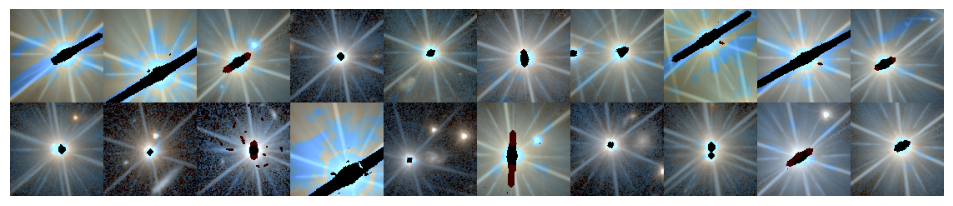

In [26]:

# Display the grid
plt.figure(figsize=(10, 7))
plt.imshow(grid_nisp)
plt.tight_layout()

plt.axis('off')
#plt.savefig("det_qality_flag_cutout.png")